# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import yeojohnson
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression,SGDClassifier,RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,roc_auc_score

In [76]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [78]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [79]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [80]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [81]:
df.duplicated().sum()

719

In [82]:
df=df.drop_duplicates()
df.duplicated().sum()

0

In [83]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,49281.000000,49281.000000,49281.000000,49281.000000,49281.000000,49281.000000,49281.000000,49281.000000,49281.000000,49281.000000
mean,1.590187,84.723281,23.053976,9.070676,3.813620,0.668229,0.295631,0.426635,7.279974,0.149977
std,1.016538,90.410229,33.832149,5.413099,1.991913,0.470854,0.456331,0.494593,1.496390,0.357052
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.000000,5.000000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.000000,9.000000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.000000,13.000000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.000000,23.000000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [84]:
df.describe(include=object)

,sales_channel,trip_type,route,booking_origin
count,49281,49281,49281,49281
unique,2,3,799,104
top,Internet,RoundTrip,AKLKUL,Australia
freq,43917,48779,2620,17691


In [85]:
df.booking_origin.unique()

array(['New Zealand', 'India', 'United Kingdom', 'China', 'South Korea',
       'Japan', 'Malaysia', 'Singapore', 'Switzerland', 'Germany',
       'Indonesia', 'Czech Republic', 'Vietnam', 'Thailand', 'Spain',
       'Romania', 'Ireland', 'Italy', 'Slovakia', 'United Arab Emirates',
       'Tonga', 'Réunion', '(not set)', 'Saudi Arabia', 'Netherlands',
       'Qatar', 'Hong Kong', 'Philippines', 'Sri Lanka', 'France',
       'Croatia', 'United States', 'Laos', 'Hungary', 'Portugal',
       'Cyprus', 'Australia', 'Cambodia', 'Poland', 'Belgium', 'Oman',
       'Bangladesh', 'Kazakhstan', 'Brazil', 'Turkey', 'Kenya', 'Taiwan',
       'Brunei', 'Chile', 'Bulgaria', 'Ukraine', 'Denmark', 'Colombia',
       'Iran', 'Bahrain', 'Solomon Islands', 'Slovenia', 'Mauritius',
       'Nepal', 'Russia', 'Kuwait', 'Mexico', 'Sweden', 'Austria',
       'Lebanon', 'Jordan', 'Greece', 'Mongolia', 'Canada', 'Tanzania',
       'Peru', 'Timor-Leste', 'Argentina', 'New Caledonia', 'Macau',
       'Myanmar (

In [86]:
(df.booking_origin=='(not set)').sum()

78

In [87]:
df=df[df.booking_origin!='(not set)']
(df.booking_origin=='(not set)').sum()

0

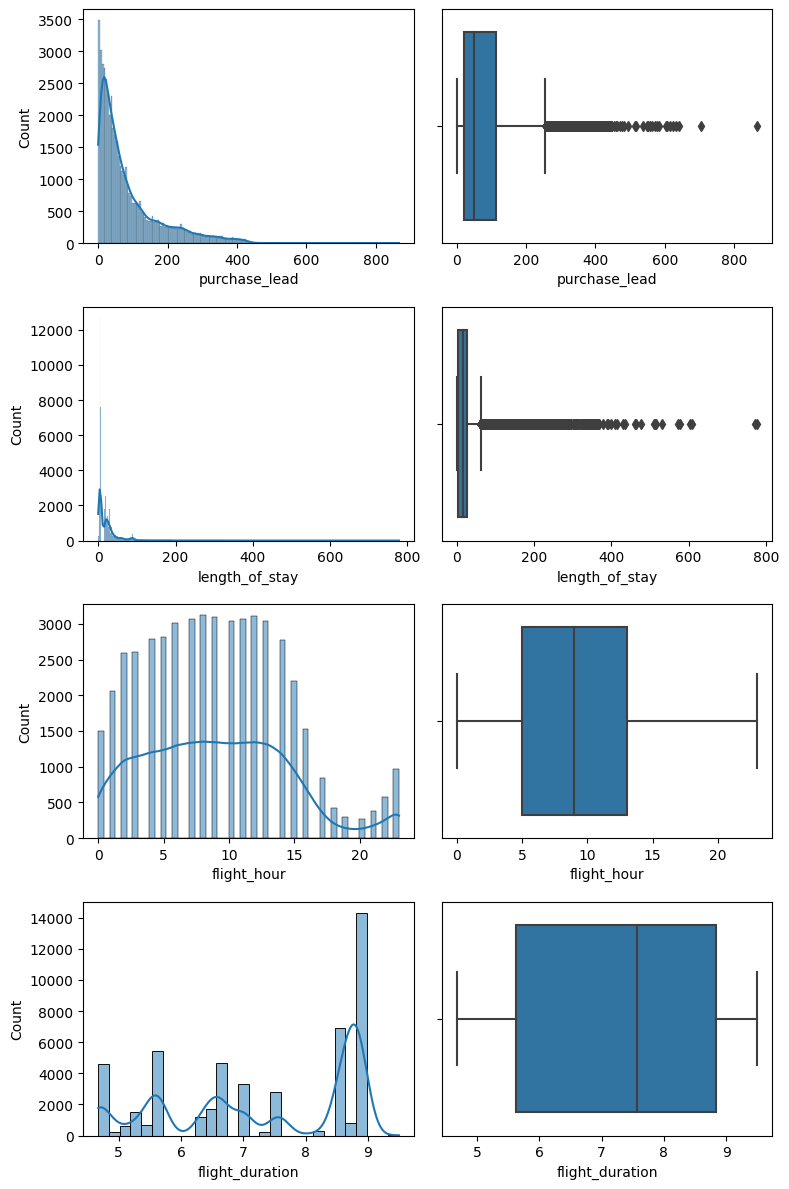

In [88]:
plt.figure(figsize=(8,12))
n=1
for i in ['purchase_lead','length_of_stay','flight_hour','flight_duration']:
    plt.subplot(4,2,n)
    sns.histplot(x=df[i],kde=True)
    plt.subplot(4,2,n+1)
    sns.boxplot(x=df[i])
    n+=2
plt.tight_layout()
plt.show()

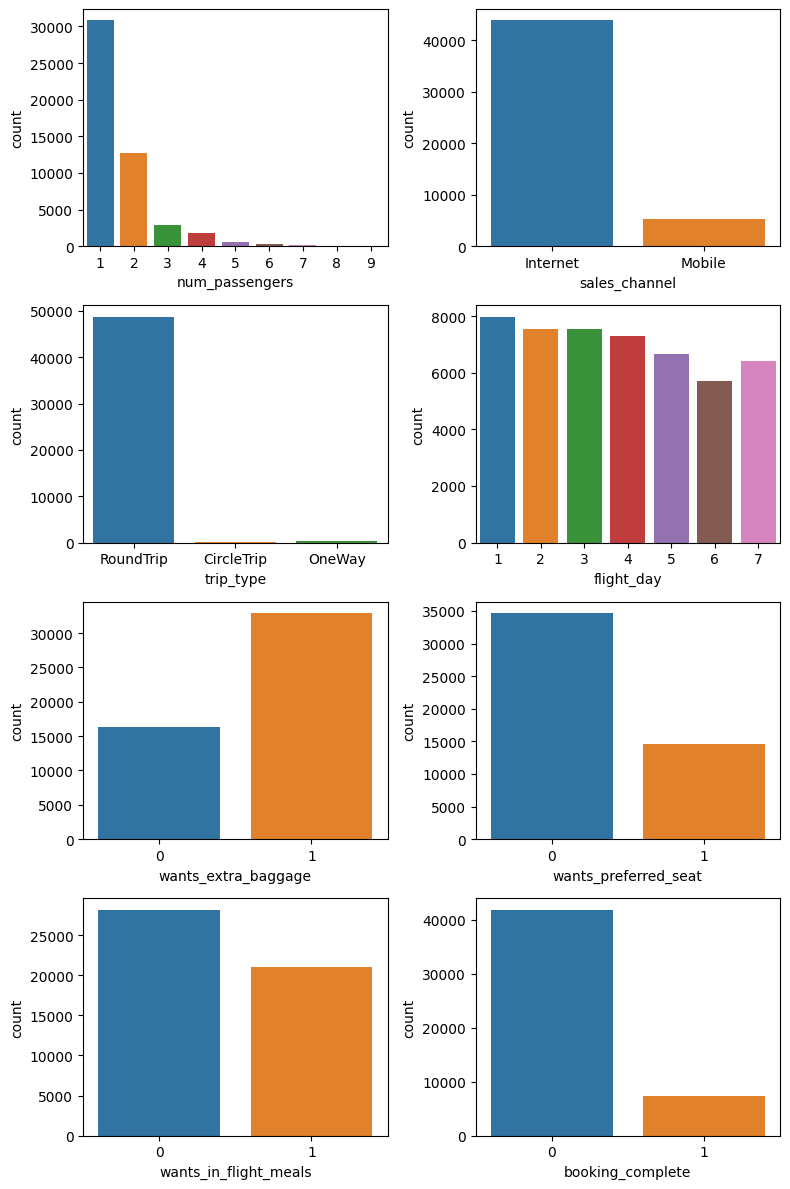

In [89]:
plt.figure(figsize=(8,12))
n=1
for i in df.drop(['purchase_lead','length_of_stay','flight_hour','flight_duration','booking_origin',
                  'route'],axis=1):
    plt.subplot(4,2,n)
    sns.countplot(x=df[i])
    n+=1
plt.tight_layout()
plt.show()

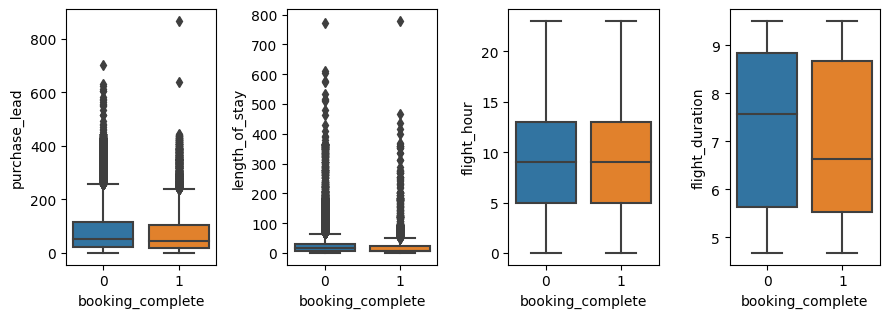

In [90]:
plt.figure(figsize=(9,6))
n=1
for i in ['purchase_lead','length_of_stay','flight_hour','flight_duration']:
    plt.subplot(2,4,n)
    sns.boxplot(x=df.booking_complete,y=df[i])
    n+=1
plt.tight_layout()
plt.show()

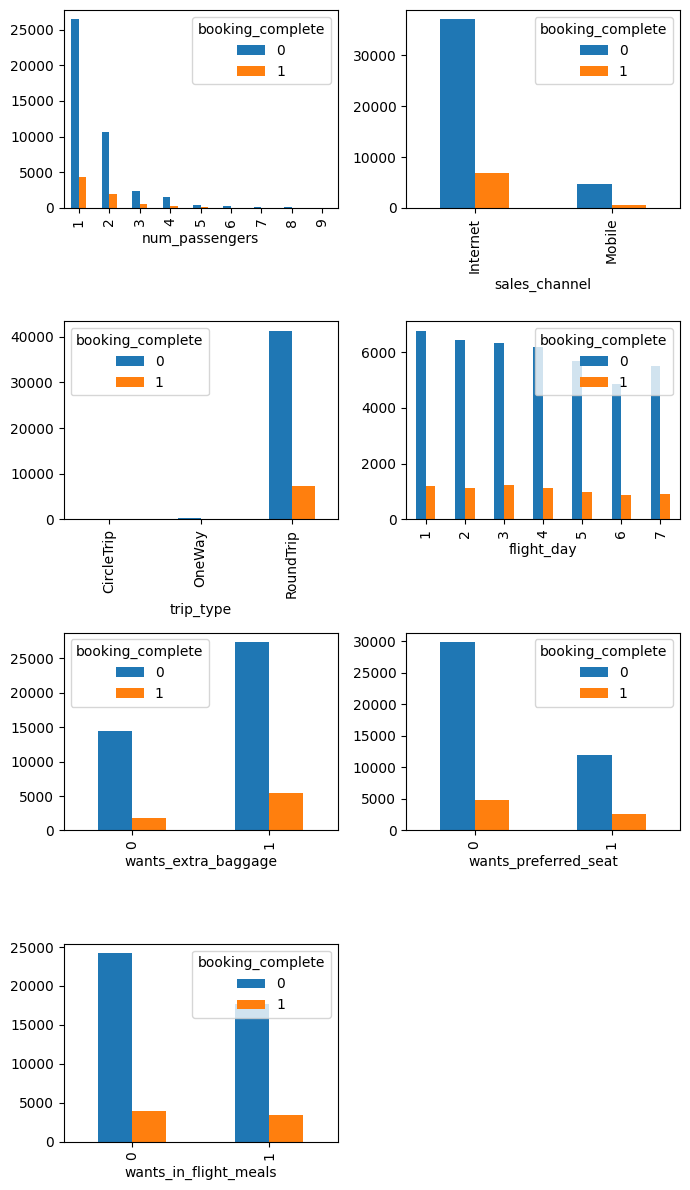

In [91]:
plt.figure(figsize=(7,12))
n=1
for i in df.drop(['purchase_lead','length_of_stay','flight_hour','flight_duration','booking_origin',
                  'route','booking_complete'],axis=1):
    ax=plt.subplot(4,2,n)
    pd.crosstab(df[i],df.booking_complete).plot.bar(ax=ax)
    n+=1
plt.tight_layout()
plt.show()

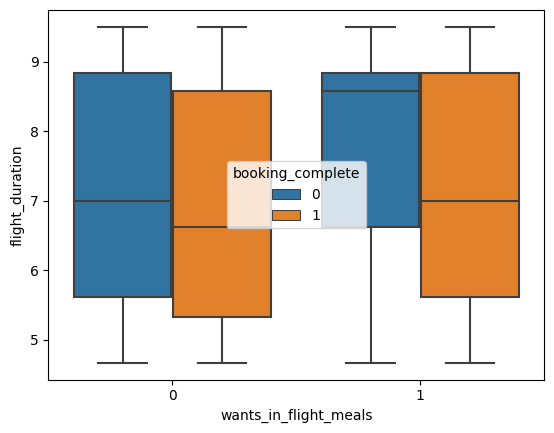

In [92]:
sns.boxplot(x=df.wants_in_flight_meals,y=df.flight_duration,hue=df.booking_complete)
plt.show()

In [93]:
df_enc=df.copy()
df_enc.num_passengers=df_enc.num_passengers.map(df_enc.groupby('num_passengers').booking_complete
                                                .mean())
df_enc.route=pd.Categorical(df_enc.route).codes
df_enc.booking_origin=pd.Categorical(df_enc.booking_origin).codes
df_enc=pd.get_dummies(df_enc,columns=['sales_channel','trip_type'],drop_first=True)
df_enc.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,sales_channel_Mobile,trip_type_OneWay,trip_type_RoundTrip
0,0.160224,262,19,7,6,0,60,1,0,0,5.52,0,0,0,1
1,0.142514,112,20,3,6,0,60,0,0,0,5.52,0,0,0,1
2,0.160224,243,22,17,3,0,35,1,1,0,5.52,0,0,0,1
3,0.142514,96,31,4,6,0,60,0,0,1,5.52,0,0,0,1
4,0.160224,68,22,15,3,0,35,1,0,1,5.52,0,0,0,1


In [94]:
x=df_enc.drop('booking_complete',axis=1)
y=df_enc.booking_complete
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=.3,random_state=1)
print(xtrain.shape,xtest.shape,ytrain.shape,ytest.shape)

(34442, 14) (14761, 14) (34442,) (14761,)


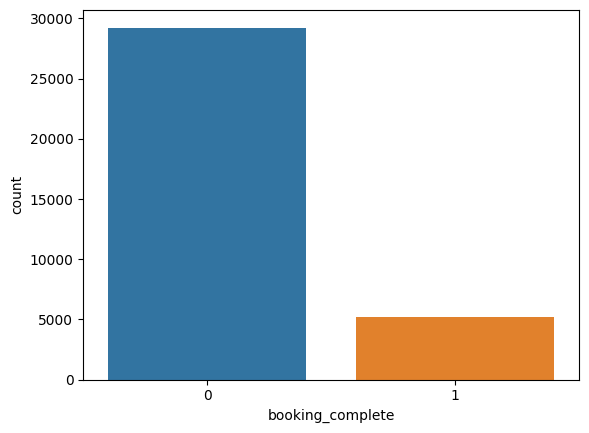

In [95]:
sns.countplot(x=ytrain)
plt.show()

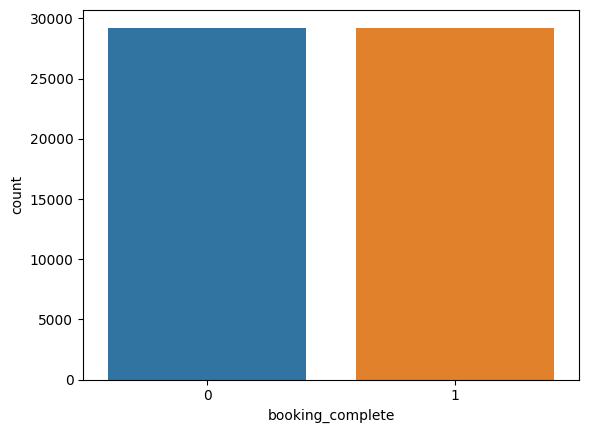

In [96]:
xtrain,ytrain=SMOTE(random_state=1).fit_resample(xtrain,ytrain)
sns.countplot(x=ytrain)
plt.show()

In [57]:
x_std=x.apply(lambda x:(x-x.mean())/x.std())
x_std.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,sales_channel_Mobile,trip_type_OneWay,trip_type_RoundTrip
0,0.946671,1.569244,0.481465,-0.382747,1.097429,-1.726054,0.692261,0.704514,-0.647973,-0.862858,-1.176906,-0.349682,-0.088805,0.101424
1,-0.681924,0.688335,0.526764,-1.122016,1.097429,-1.726054,0.692261,-1.419389,-0.647973,-0.862858,-1.176906,-0.349682,-0.088805,0.101424
2,0.946671,1.485801,0.609772,1.465425,-0.408646,-1.726054,-0.070485,0.704514,1.543244,-0.862858,-1.176906,-0.349682,-0.088805,0.101424
3,-0.681924,0.542268,0.895801,-0.937199,1.097429,-1.726054,0.692261,-1.419389,-0.647973,1.158915,-1.176906,-0.349682,-0.088805,0.101424
4,0.946671,0.229833,0.609772,1.095790,-0.408646,-1.726054,-0.070485,0.704514,-0.647973,1.158915,-1.176906,-0.349682,-0.088805,0.101424


In [58]:
xtrain_std,xtest_std,ytrain,ytest=train_test_split(x_std,y,test_size=.3,random_state=1)
xtrain_std,ytrain=SMOTE(random_state=1).fit_resample(xtrain_std,ytrain)
ytrain.value_counts()

0    29245
1    29245
Name: booking_complete, dtype: int64

In [59]:
lr=LogisticRegression(solver='liblinear').fit(xtrain,ytrain)
print('Train score =',lr.score(xtrain,ytrain),'\nTest score =',lr.score(xtest,ytest))

Train score = 0.6520772781672081 
Test score = 0.6017207506266513


In [60]:
sgd=SGDClassifier(random_state=1).fit(xtrain_std,ytrain)
print('Train score =',sgd.score(xtrain_std,ytrain),'\nTest score =',sgd.score(xtest_std,ytest))

Train score = 0.6253889553769875 
Test score = 0.6068017072014091


In [61]:
knn=KNeighborsClassifier(40).fit(xtrain_std,ytrain)
print('Train score =',knn.score(xtrain_std,ytrain),'\nTest score =',knn.score(xtest_std,ytest))

Train score = 0.7378868182595315 
Test score = 0.6162861594742903


In [62]:
gnb=GaussianNB().fit(xtrain,ytrain)
print('Train score =',gnb.score(xtrain,ytrain),'\nTest score =',gnb.score(xtest,ytest))

Train score = 0.5619251154043426 
Test score = 0.27118758891674005


In [63]:
rc=RidgeClassifier(random_state=1).fit(xtrain,ytrain)
print('Train score =',rc.score(xtrain,ytrain),'\nTest score =',rc.score(xtest,ytest))

Train score = 0.6525559924773465 
Test score = 0.6002980827857192


In [64]:
dt=DecisionTreeClassifier(max_depth=7,random_state=1).fit(xtrain,ytrain)
print('Train score =',dt.score(xtrain,ytrain),'\nTest score =',dt.score(xtest,ytest))

Train score = 0.7805778765600957 
Test score = 0.8014362170584649


In [65]:
rf=RandomForestClassifier(max_depth=10,random_state=1).fit(xtrain,ytrain)
print('Train score =',rf.score(xtrain,ytrain),'\nTest score =',rf.score(xtest,ytest))

Train score = 0.8179346896905454 
Test score = 0.7459521712621097


In [66]:
sc=StackingClassifier([('LR',LogisticRegression(solver='liblinear')),('SGD',SGDClassifier())],
                      DecisionTreeClassifier(max_depth=7)).fit(xtrain_std,ytrain)
print('Train score =',sc.score(xtrain_std,ytrain),'\nTest score =',sc.score(xtest_std,ytest))

Train score = 0.6336638741665241 
Test score = 0.6328839509518326


In [97]:
xgb=XGBClassifier(max_depth=4,random_state=1).fit(xtrain,ytrain)
print('Train score =',xgb.score(xtrain,ytrain),'\nTest score =',xgb.score(xtest,ytest))

Train score = 0.8674303299709352 
Test score = 0.8128175597859224


In [68]:
%%time
pg={'max_depth':[3,4,5],'learning_rate':[0.01,0.1,0.2],'gamma':[0.1,0.5,1.0]}
gscv=GridSearchCV(XGBClassifier(random_state=1,n_jobs=-1),pg,scoring='accuracy',n_jobs=-1,
                  cv=3).fit(xtrain,ytrain)

CPU times: total: 10.7 s
Wall time: 3min 26s


In [69]:
gscv.best_params_

{'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 5}

In [98]:
xgb_tuned=XGBClassifier(max_depth=5,gamma=.5,learning_rate=.2,random_state=1).fit(xtrain,ytrain)
print('Train score =',xgb_tuned.score(xtrain,ytrain),'\nTest score =',xgb_tuned.score(xtest,ytest))

Train score = 0.8724226363480937 
Test score = 0.8151209267664792


In [99]:
xgb_final=XGBClassifier(max_depth=4,random_state=1).fit(xtrain,ytrain)
pred=xgb_final.predict(xtest)
print(classification_report(ytest,pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     12581
           1       0.36      0.35      0.36      2180

    accuracy                           0.81     14761
   macro avg       0.63      0.62      0.62     14761
weighted avg       0.81      0.81      0.81     14761



In [110]:
prob=xgb_final.predict_proba(xtest)[:,1]
print('AUC =',roc_auc_score(ytest,prob))

AUC = 0.7583679955721787


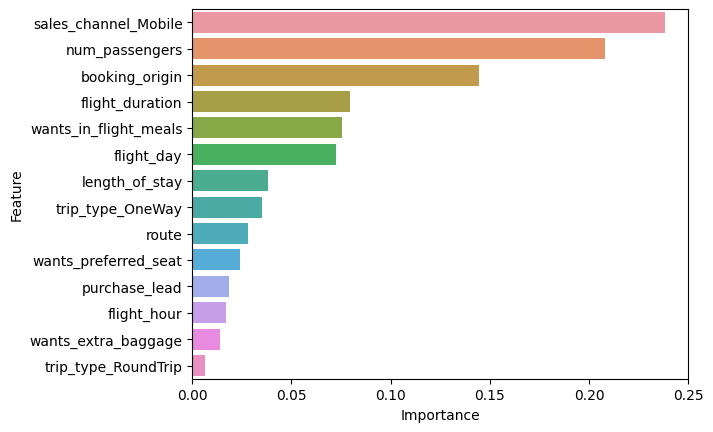

In [120]:
fi=pd.Series(xgb_final.feature_importances_,x.columns).sort_values(ascending=False)
sns.barplot(x=fi.values,y=fi.index)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()